In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

# import

In [3]:
atp = pd.read_csv("ATP.csv", dtype = object)

In [4]:
atp.shape

(169690, 49)

# taux de remplissage des variables

In [5]:
# % lignes renseignées par champs
(atp.count()/atp.shape[0]).sort_values()

draw_size             0.007260
winner_entry          0.086911
loser_entry           0.149325
loser_seed            0.193606
winner_seed           0.384790
minutes               0.483841
l_SvGms               0.491573
w_1stIn               0.491573
w_SvGms               0.491573
w_ace                 0.491573
w_bpFaced             0.491573
w_bpSaved             0.491573
w_df                  0.491573
w_svpt                0.491573
l_1stIn               0.491573
l_2ndWon              0.491573
w_2ndWon              0.491573
l_1stWon              0.491573
l_svpt                0.491573
l_df                  0.491573
l_bpSaved             0.491573
l_bpFaced             0.491573
l_ace                 0.491573
w_1stWon              0.491573
loser_rank_points     0.548206
winner_rank_points    0.555666
loser_ht              0.819447
loser_rank            0.859856
winner_rank           0.882627
winner_ht             0.889174
loser_age             0.970593
surface               0.985037
winner_a

In [6]:
# suppression des variables les moins renseignées
atp = atp.drop(columns = ['draw_size','winner_entry', 'loser_entry', 'winner_seed', 'loser_seed'], axis = 1)

# Créations de variables

### Annee & date

In [7]:
# variable date
atp['date'] = pd.to_datetime(atp['tourney_date'], format = '%Y-%m-%d')
# variable annee
atp['annee'] = atp['tourney_date'].astype(str).str[:4].astype(int)

In [8]:
# variable minute renseigné par annee
# atp.loc[:,'minutes'] = pd.to_numeric(atp.loc[:,'minutes'], errors = 'coerce')
# atp.loc[:,['minutes','annee']].groupby('annee').agg(['count','size'])
# # variable minute renseigné par annee & tournoi
# atp.loc[:,['minutes','annee','tourney_name']].groupby(['tourney_name','annee']).agg(['count','size'])


In [9]:
# # variable w_1stIn renseigné par annee
# atp.loc[:,'w_1stIn'] = pd.to_numeric(atp.loc[:,'w_1stIn'], errors = 'coerce')
# atp.loc[:,['w_1stIn','annee']].groupby('annee').agg(['count','size'])

## Tenir compte du passif d'un joueur

### estimer le temps passé sur les courts/difficulté des tours prec du joueur pendant le tournoi

#### La variable minute n'étant pas assez souvent définie on va utiliser le score du match

In [10]:
# Rectification de la variable score :
#  - on enlève les caractères alphabetiques
#  - on enlève les scores de tie break entre parenthèses
#  - on corrige les scores interprétés à tort en date
atp['score_ok'] = atp['score'].astype(str)\
.str.replace('-Jun','-6')\
.str.replace('-Jul','-7')\
.str.replace('-Feb','-2')\
.str.replace('-Mar','-3')\
.str.replace('-Apr','-4')\
.str.replace('\([^)]*\)', '', regex=True)\
.str.replace('\[[^)]*\]', '', regex=True)
atp['score_ok'] = atp['score_ok'].astype(str).str.replace('[a-z]|[A-Z]|/', '', regex=True).str.strip()

#### nombre de sets joués

In [11]:
atp['nmb_sets'] = atp['score_ok'].str.replace('[0-9]| ','').str.len()
atp['match'] = 1

#### nombre de jeux pour le gagnant / perdant

In [12]:
# décomposition de score_ok en listes imbriquées, récupération du nombre de jeux gagnés du gagnant/perdant
score_list = [[j.split('-') for j in g] for e in list(atp['score_ok']) for s in [e.split(' ')] for g in [s]]
rslt = []
cnt=0
for match in score_list:
    cnt+=1
    w_g = 0
    l_g = 0
    for manche in match:
        if manche[0]:
            w_g += int(manche[0])
            l_g += int(manche[1])
    rslt.append((w_g,l_g))

In [13]:
atp['w_nbjeux'] = [e[0] for e in rslt]
atp['l_nbjeux'] = [e[1] for e in rslt]

### historique du tournoi 

#### pour chaque joueur gagnant/perdant recuperer le nombre de matchs, sets, jeux gagnés et concédés au cours du tournoi avant le match en cours

In [14]:
atp['match_num'] = pd.to_numeric(atp['match_num'])

In [15]:
# somme cumulées par doublet tournoi-joueurs gagnant/perdant
histo_w = atp.loc[:,['winner_id','tourney_id','w_nbjeux','l_nbjeux','nmb_sets','match']]\
.groupby(by=['winner_id','tourney_id'])['w_nbjeux','l_nbjeux','nmb_sets','match'].apply(lambda x: x.cumsum())\
.rename(columns={'w_nbjeux':'winner_nbjeux_trny',
                 'l_nbjeux':'winner_opponent_nbjeux_trny',
                 'nmb_sets':'winner_nmb_sets_trny',
                 'match':'winner_nbmatchs_trny'})
histo_w = atp.loc[:,['winner_id','tourney_id','match_num']].join(histo_w)

histo_l = atp.loc[:,['loser_id','tourney_id','w_nbjeux','l_nbjeux','nmb_sets','match']]\
.groupby(by=['loser_id','tourney_id'])['w_nbjeux','l_nbjeux','nmb_sets','match'].apply(lambda x: x.cumsum())\
.rename(columns={'w_nbjeux':'winner_nbjeux_trny',
                 'l_nbjeux':'winner_opponent_nbjeux_trny',
                 'nmb_sets':'winner_nmb_sets_trny',
                 'match':'winner_nbmatchs_trny'})
histo_l = atp.loc[:,['loser_id','tourney_id','match_num']].join(histo_l)


In [16]:
# concaténation des dataframes des joueurs gagnants et perdants
histo = histo_l.append(histo_w, ignore_index = True)
histo = histo.sort_values(['tourney_id','match_num'])
histo['player_id'] = histo['winner_id'].combine_first(histo['loser_id'])

/home/ava6210/.local/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [17]:
# on applique un lag de 1 pour ne pas tenir du résultat du match à pronostiquer
histo['winner_nbjeux_trny'] = histo.groupby(['tourney_id','player_id'])['winner_nbjeux_trny'].shift(1)
histo['winner_opponent_nbjeux_trny'] = histo.groupby(['tourney_id','player_id'])['winner_opponent_nbjeux_trny'].shift(1)
histo['winner_nmb_sets_trny'] = histo.groupby(['tourney_id','player_id'])['winner_nmb_sets_trny'].shift(1)
histo['winner_nbmatchs_trny'] = histo.groupby(['tourney_id','player_id'])['winner_nbmatchs_trny'].shift(1)

In [18]:
# on merge 2 fois (gagnant puis perdant) en renommant les variables comme necessaire 
# on initialise à zero les variables pour le premier match de chaque tournoi
atp_histo = pd.merge(pd.merge(atp, histo.loc[:,['winner_id','tourney_id','match_num','winner_nbjeux_trny',
                           'winner_opponent_nbjeux_trny','winner_nmb_sets_trny','winner_nbmatchs_trny']],
                            how='left', left_on=['winner_id','tourney_id','match_num'], right_on=['winner_id','tourney_id','match_num']),
                                         histo.loc[:,['loser_id','tourney_id','match_num','winner_nbjeux_trny',
                                         'winner_opponent_nbjeux_trny','winner_nmb_sets_trny','winner_nbmatchs_trny']]\
                                         .rename(columns={'winner_nbjeux_trny':'loser_nbjeux_trny',
                                                          'winner_opponent_nbjeux_trny':'loser_opponent_nbjeux_trny',
                                                          'winner_nmb_sets_trny':'loser_nmb_sets_trny',
                                                          'winner_nbmatchs_trny':'loser_nbmatchs_trny'}),
                                         how='left', left_on=['loser_id','tourney_id','match_num'], right_on=['loser_id','tourney_id','match_num'])

atp_histo[['winner_nbjeux_trny','winner_opponent_nbjeux_trny','winner_nmb_sets_trny','winner_nbmatchs_trny','loser_nbjeux_trny','loser_opponent_nbjeux_trny','loser_nmb_sets_trny','loser_nbmatchs_trny']] = atp_histo[['winner_nbjeux_trny','winner_opponent_nbjeux_trny','winner_nmb_sets_trny','winner_nbmatchs_trny','loser_nbjeux_trny','loser_opponent_nbjeux_trny','loser_nmb_sets_trny','loser_nbmatchs_trny']].fillna(value=0)

## Visualisations

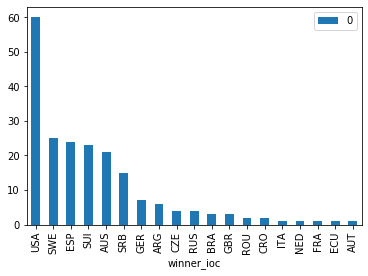

In [19]:
# gagnant grands chelems par pays
WinChelemPays = pd.DataFrame(atp_histo.loc[(atp_histo['tourney_level'] == 'G') & (atp_histo['round'] == 'F'),]\
.groupby(['winner_ioc'])\
.size()\
.sort_values(ascending = False))
WinChelemPays.plot(kind = 'bar')

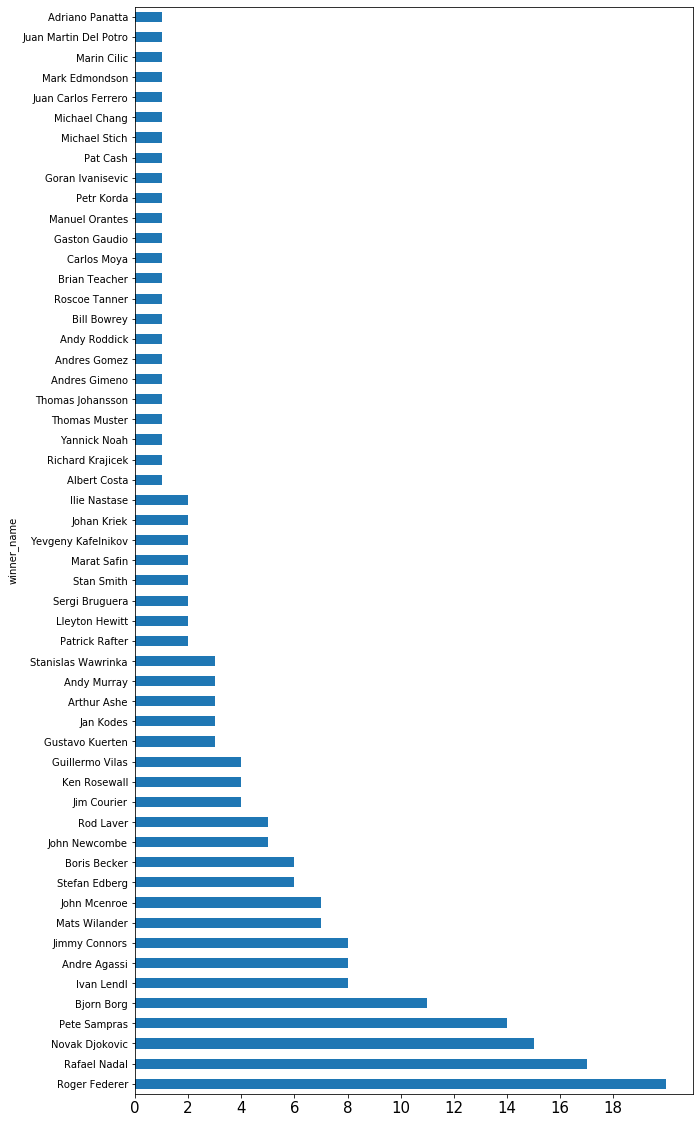

In [20]:
# Nombre de grands chelems par joueur
grandSlamWinner = atp_histo[(atp_histo['tourney_level'] == 'G') & (atp_histo['round'] == 'F')]\
.groupby(['winner_name']).count().sort_values('annee', ascending = False).iloc[:, 0]
plt.figure(figsize = (10, 20))
plt.xticks(fontsize = 15)
plt.xticks(np.arange(0, 20, step = 2))
grandSlamWinner.plot(kind = 'barh')

### Visualisation des variables continues du match en cours exploitables pour la modélisation

In [21]:
def draw_double_histo(var1,var2,df,xlim_min=0,xlim_max=None):
    atp1 = df[(df[var1].notnull()) & (df[var2].notnull())]
    atp1.loc[:,var1] = pd.to_numeric(atp1.loc[:,var1], errors = 'coerce')
    atp1.loc[:,var2] = pd.to_numeric(atp1.loc[:,var2], errors = 'coerce')
    sns.distplot(atp1[var1] , color="skyblue", label=var1)
    sns.distplot(atp1[var2] , color="red", label=var2)
    plt.xlim(xlim_min, xlim_max)
    plt.legend()

#### Age

/home/ava6210/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


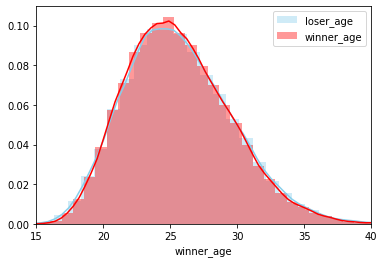

In [22]:
draw_double_histo('loser_age','winner_age',atp_histo,15,40)

#### Taille

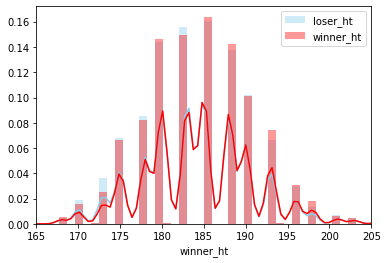

In [23]:
draw_double_histo('loser_ht','winner_ht',atp_histo,165,205)

#### Classement atp

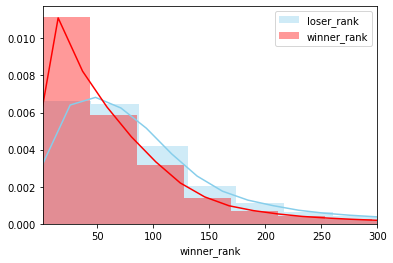

In [24]:
draw_double_histo('loser_rank','winner_rank',atp_histo,1,300)

#### Nombre de point atp

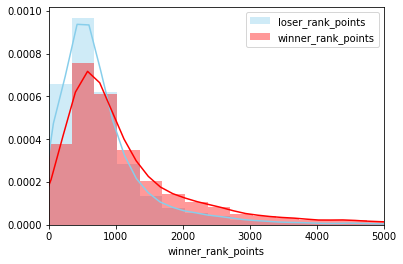

In [25]:
draw_double_histo('loser_rank_points','winner_rank_points',atp_histo,0,5000)

### Visualisation des variables continues historiques exploitables pour la modélisation

In [26]:
def draw_double_bar(varl,varw,df,xli=0,xlim=100,figsize=(20, 8),fontsize=15):
    df_to_plot = pd.DataFrame(df.groupby(varl).size()).rename({0:'loser'},axis=1)\
                    .join(pd.DataFrame(df.groupby(varw).size()).rename({0:'winner'},axis=1)).loc[xli:xlim,]
                    #.sort_values('winner', ascending=False)

    df_to_plot.plot(kind = 'bar', figsize = figsize, fontsize = fontsize)

##### nombre de matchs disputés depuis le début du tournoi

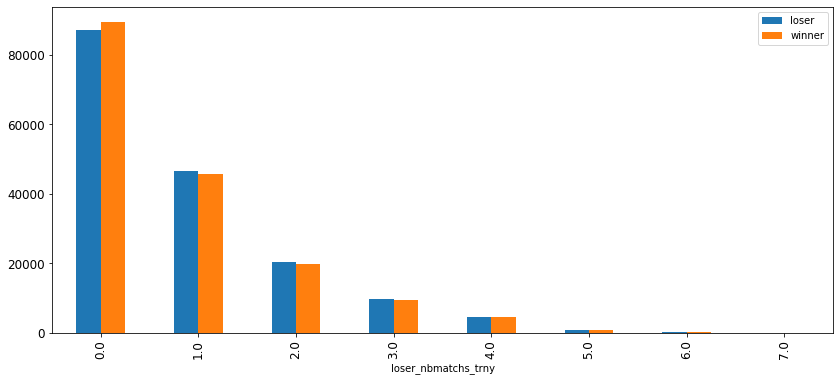

In [27]:
draw_double_bar('loser_nbmatchs_trny','winner_nbmatchs_trny',atp_histo,0,7,(14,6),12)

##### nombre de sets disputés depuis le début du tournoi

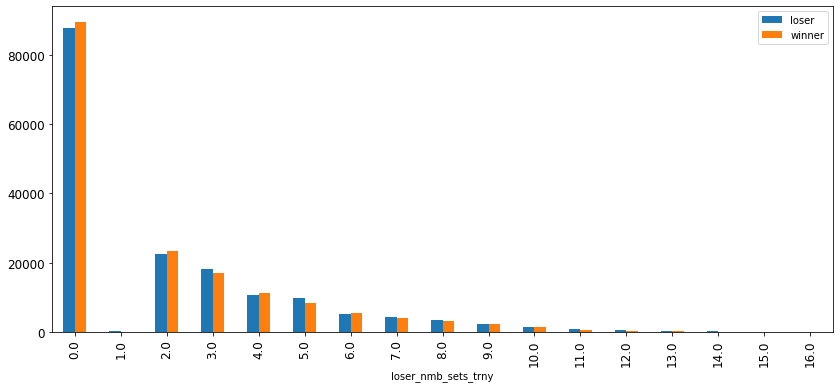

In [28]:
draw_double_bar('loser_nmb_sets_trny','winner_nmb_sets_trny',atp_histo,0,16,(14,6),12)

##### nombre de jeux remporté depuis le début du tournoi

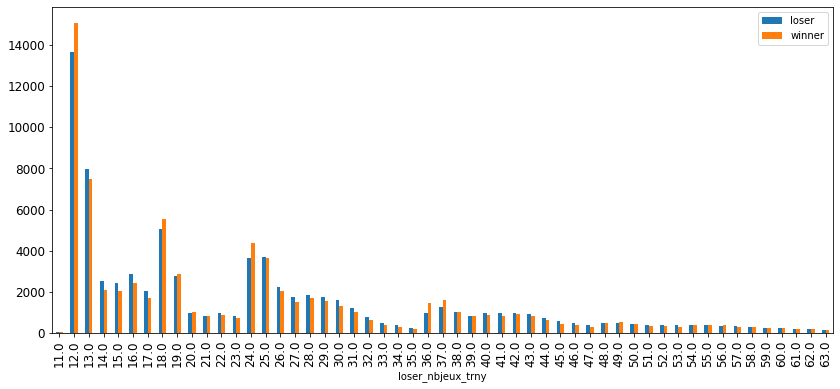

In [29]:
draw_double_bar('loser_nbjeux_trny','winner_nbjeux_trny',atp_histo,11,63,(14,6),12)

##### nombre de jeux concedés depuis le début du tournoi

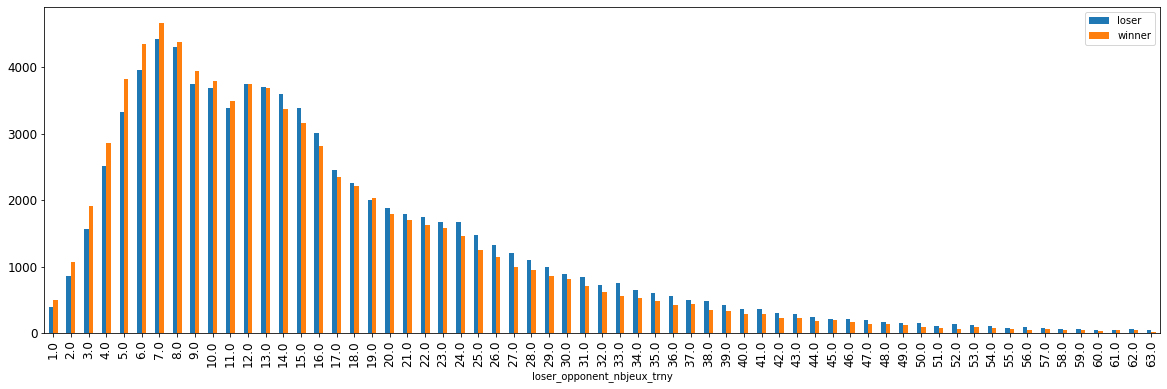

In [30]:
draw_double_bar('loser_opponent_nbjeux_trny','winner_opponent_nbjeux_trny',atp_histo,1,63,(20,6),12)

### Visualisation des variables discrètes du match en cours exploitables pour la modélisation

#### surface

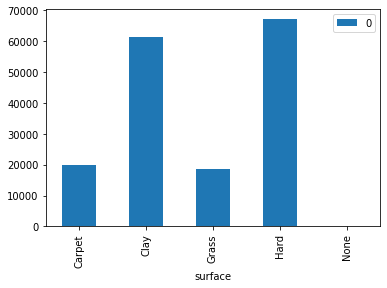

In [31]:
pd.DataFrame(atp_histo.loc[:,['surface']].groupby('surface').size()).plot(kind = 'bar')

#### type de tournoi 
'A' = other tour-level events

'C' = Challengers

'D' = Davis Cup

'F' = Tour finals and other season-ending events

'G' = Grand Slams

'M' = Masters 1000s

'S' = Satellites/ITFs

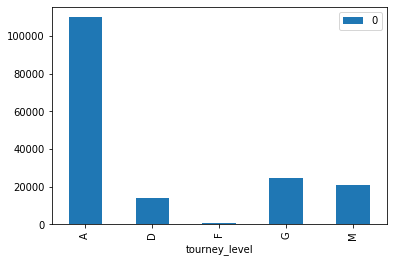

In [32]:
pd.DataFrame(atp_histo.loc[:,['tourney_level']].groupby('tourney_level').size()).plot(kind = 'bar')

#### Avancement dans le tournoi

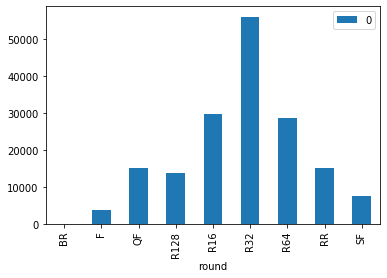

In [33]:
pd.DataFrame(atp_histo.loc[:,['round']].groupby('round').size()).plot(kind = 'bar')

#### Droitier / Gaucher

([<matplotlib.axis.XTick at 0x7fbbc64367f0>,
 <a list of 3 Text xticklabel objects>)

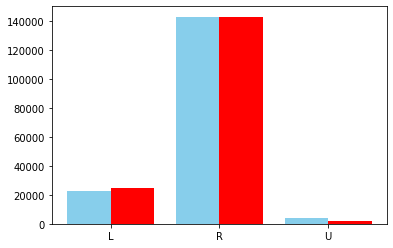

In [34]:
X = pd.DataFrame(atp_histo.groupby('winner_hand').size()).index
_X = np.arange(len(X))
plt.bar(_X+0.2,atp_histo.groupby('winner_hand').size(),0.4,color='red')
plt.bar(_X-0.2,atp_histo.groupby('loser_hand').size(),0.4,color='skyblue')
plt.xticks(_X, X)

#### nationalité

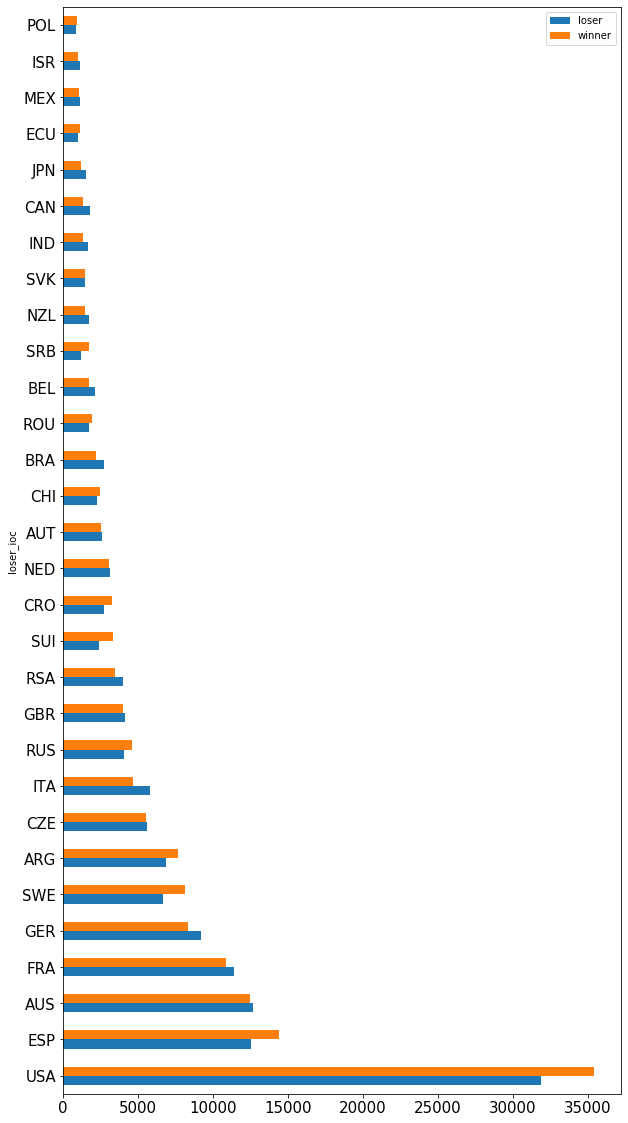

In [35]:

df_to_plot = pd.DataFrame(atp_histo.groupby('loser_ioc').size()).rename({0:'loser'},axis=1)\
                .join(pd.DataFrame(atp_histo.groupby('winner_ioc').size()).rename({0:'winner'},axis=1))\
                .sort_values('winner', ascending=False).head(30)

df_to_plot.plot(kind = 'barh', figsize = (10, 20), fontsize = 15)

## Création de la variable cible en concaténant le dataframe avec lui-même avec les variables winner/looser inversées

In [36]:
atp_histo2 = atp_histo.copy()
atp_histo2.rename(columns = {'winner_hand' : 'loser_hand',
                       'winner_ioc' : 'loser_ioc',
                       'winner_rank' : 'loser_rank',
                       'winner_rank_points' : 'loser_rank_points',
                       'winner_ht' : 'loser_ht',
                       'winner_age' : 'loser_age',
                       'winner_nbmatchs_trny' : 'loser_nbmatchs_trny',
                       'winner_nmb_sets_trny' : 'loser_nmb_sets_trny',
                       'winner_nbjeux_trny' : 'loser_nbjeux_trny',
                       'winner_opponent_nbjeux_trny' : 'loser_opponent_nbjeux_trny',
                       'loser_hand' : 'winner_hand',
                       'loser_ioc' : 'winner_ioc',
                       'loser_rank' : 'winner_rank',
                       'loser_rank_points' : 'winner_rank_points',
                       'loser_ht' : 'winner_ht',
                       'loser_age' : 'winner_age',
                       'loser_nbmatchs_trny' : 'winner_nbmatchs_trny',
                       'loser_nmb_sets_trny' : 'winner_nmb_sets_trny',
                       'loser_nbjeux_trny' : 'winner_nbjeux_trny',
                       'loser_opponent_nbjeux_trny' : 'winner_opponent_nbjeux_trny'},
            inplace = True)
atp_histo['ztarget'] = 1
atp_histo2['ztarget'] = 0

In [37]:
# stack
data = atp_histo.append(atp_histo2, ignore_index = True, sort = True)
data.shape

(339488, 60)

### preparation des donnees avant modélisation

In [38]:
# suppression des lignes non remplies sur les variables de modélisations
data.dropna(axis = 0,
            subset = ['surface', 'tourney_level', 'round',
                      'winner_hand', 'loser_hand', 'winner_ioc', 'loser_ioc', 'winner_rank', 'loser_rank',
                      'winner_rank_points', 'loser_rank_points', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age',
                      'winner_nbmatchs_trny', 'winner_nmb_sets_trny', 'winner_nbjeux_trny', 'winner_opponent_nbjeux_trny',
                      'loser_nbmatchs_trny', 'loser_nmb_sets_trny', 'loser_nbjeux_trny', 'loser_opponent_nbjeux_trny'],
            how = 'any',
            inplace = True)

In [39]:
# suppression des variables inutiles à la modélisation
garde = ['surface', 'tourney_level', 'round',
                      'winner_hand', 'loser_hand', 'winner_ioc', 'loser_ioc', 'winner_rank', 'loser_rank',
                      'winner_rank_points', 'loser_rank_points', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age',
                      'winner_nbmatchs_trny', 'winner_nmb_sets_trny', 'winner_nbjeux_trny', 'winner_opponent_nbjeux_trny',
                      'loser_nbmatchs_trny', 'loser_nmb_sets_trny', 'loser_nbjeux_trny', 'loser_opponent_nbjeux_trny']
garde.append('ztarget')
garde.append('tourney_id')
garde.append('match_num')
to_drop = [c for c in data.columns if c not in garde]
data = data.drop(to_drop,axis=1)

In [40]:
# dummyfication
to_dummy = ['surface', 'tourney_level', 'round', 'winner_hand', 'winner_ioc', 'loser_hand', 'loser_ioc']
for f in to_dummy:
    dummies = pd.get_dummies(data[f], prefix=f, drop_first = True)
    data = pd.concat([data, dummies], axis = 1)

data = data.drop(to_dummy, axis = 1)

In [41]:
# normalisation des var quanti
to_normalize = ['loser_age', 'loser_ht', 'loser_rank', 'loser_rank_points',
                  'winner_age', 'winner_ht', 'winner_rank', 'winner_rank_points',
                'loser_nbmatchs_trny', 'loser_nmb_sets_trny', 'loser_nbjeux_trny', 'loser_opponent_nbjeux_trny',
                'winner_nbmatchs_trny', 'winner_nmb_sets_trny', 'winner_nbjeux_trny', 'winner_opponent_nbjeux_trny'
               ]

var_unnormalized = {}
for v in to_normalize:
    data[v] = pd.to_numeric(data[v])
    mean, std = data[v].mean(), data[v].std()
    var_unnormalized[v] = [mean, std]
    data.loc[:, v] = (data[v] - mean)/std


### séparation en Train et Test

In [42]:
# création d'un id de match qu'on hash pour ne pas avoir le même match en train et en test
data['match_id'] = data['match_num'].astype(str).map(str) + data['tourney_id'].astype(str)
data['match_id_hash'] = data['match_id'].apply(hash)
data = data.sort_values('match_id_hash')

In [43]:
X, y = data.drop(['match_num','tourney_id','match_id','match_id_hash','ztarget'], axis = 1), data[['ztarget']]

In [44]:
# on séléctionne 10% en test
X_test, X_train, y_test, y_train = X[:16782], X[16782:], y[:16782], y[16782:]

### modélisation

#### deep network

In [45]:
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout


Using TensorFlow backend.
/home/ava6210/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ava6210/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ava6210/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ava6210/.local/lib/python3.6/site-packages/tensorflow/py

In [46]:
n_cols = X_train.shape[1]
model = Sequential()
model.add(Dropout(0.1, seed = 42, input_shape = (n_cols, )))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(64, activation = 'relu'))
model.add(Dense(23, activation = 'relu'))
model.add(Dense(23, activation = 'relu'))
model.add(Dense(13, activation = 'relu'))
model.add(Dense(7, activation = 'relu'))
# model.add(Dense(4, activation = 'relu'))
# model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [47]:
history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.1,
                    batch_size = 128, callbacks = [early_stopping])

Train on 135932 samples, validate on 15104 samples
Epoch 1/30
135932/135932 [==============================] - 3s 23us/step - loss: 0.6411 - acc: 0.6296 - val_loss: 0.6180 - val_acc: 0.6586
Epoch 2/30
135932/135932 [==============================] - 3s 21us/step - loss: 0.6254 - acc: 0.6446 - val_loss: 0.6155 - val_acc: 0.6598
Epoch 3/30
135932/135932 [==============================] - 3s 20us/step - loss: 0.6225 - acc: 0.6478 - val_loss: 0.6159 - val_acc: 0.6574
Epoch 4/30
135932/135932 [==============================] - 3s 20us/step - loss: 0.6210 - acc: 0.6499 - val_loss: 0.6135 - val_acc: 0.6594
Epoch 5/30
135932/135932 [==============================] - 3s 20us/step - loss: 0.6194 - acc: 0.6514 - val_loss: 0.6137 - val_acc: 0.6621
Epoch 6/30
135932/135932 [==============================] - 3s 20us/step - loss: 0.6189 - acc: 0.6513 - val_loss: 0.6134 - val_acc: 0.6604
Epoch 7/30
135932/135932 [==============================] - 3s 20us/step - loss: 0.6174 - acc: 0.6526 - val_loss: 0

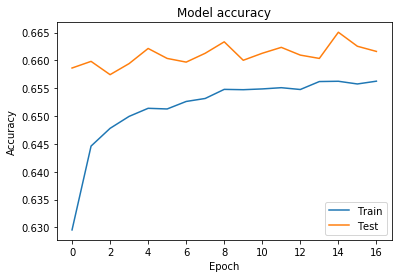

In [48]:
# Accuracy de training et validation
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'lower right')
plt.show()


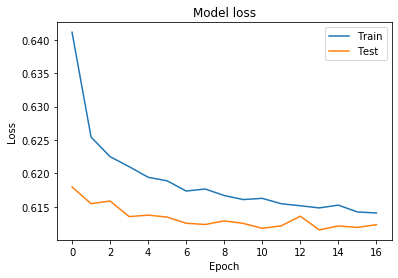

In [49]:
# Loss values de training et validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [50]:
# Perf
print(model.evaluate(X_test, y_test))
mod_wts = model.get_weights()
model.summary()

16782/16782 [==============================] - 0s 15us/step
[0.6144130730810814, 0.6554046001668454]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 208)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4807      
_________________________________________________________________
dense_2 (Dense)              (None, 23)                552       
_________________________________________________________________
dense_3 (Dense)              (None, 13)                312       
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 98        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 5,777

In [51]:
y_test2 = y_test.copy()
y_test2['predict'] = model.predict_classes(X_test)
y_test2.groupby(['ztarget','predict']).size()

ztarget  predict
0        0          5487
         1          2904
1        0          2879
         1          5512
dtype: int64

#### random forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=2,max_features=100,
                             random_state=0)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features=100, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [54]:
y_test2 = y_test.copy()
y_test2['predict'] = clf.predict(X_test)
y_test2.groupby(['ztarget','predict']).size()

ztarget  predict
0        0          5780
         1          2611
1        0          3477
         1          4914
dtype: int64

# PERSPECTIVES d'améliorations:
 - Etoffer les variables d'historiques avec le résultats des précédentes confrontations entre 2 joueurs si elle existent
 - Ajouter le delai depuis le dernier tournoi pour prendre en compte un éventuel retour de blessure
 - Ajouter des %victoire par surface
 - Tester en grid search plusieurs réseaux de neurones / randoms forest